#VECTORIZATION!!!!!!!!!!!!!!

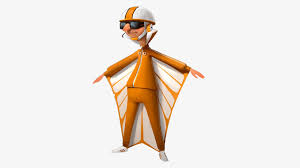

# The Task of The Week: Vectorize a JSON Dataset and Link it to an LLM to Enable the User to Send Their Queries.

---



In [ ]:
!pip install -q langchain sentence-transformers faiss-cpu transformers accelerate

# Convert the JSON to a Data Frame



In [ ]:
import json
import pandas as pd
import numpy as np

with open("/content/LeJson.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.head(2)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n"


# Convert the now Data Frame to Text

from what i read, doing this is required for datasets that deals with more than one feature or entry

In [ ]:
def hospital_to_text(row):
    return (
        f"Hospital Name: {row['Hospital Name']}. "
        f"Type: {row['Hospital Type']}. "
        f"Ownership: {row['Hospital Ownership']}. "
        f"Overall Rating: {row['Hospital overall rating']}. "
        f"Mortality: {row['Mortality national comparison']}. "
        f"Safety: {row['Safety of care national comparison']}. "
        f"Readmission: {row['Readmission national comparison']}. "
        f"Patient Experience: {row['Patient experience national comparison']}. "
        f"Effectiveness: {row['Effectiveness of care national comparison']}. "
        f"Timeliness: {row['Timeliness of care national comparison']}. "
        f"Efficiency of Imaging: {row['Efficient use of medical imaging national comparison']}."
    )

texts = df.apply(hospital_to_text, axis=1).tolist()
print(f"Prepared {len(texts)} hospital descriptions for embedding.")

Prepared 4812 hospital descriptions for embedding.


# Embedding The Data Using The SentenceTransformer with The all-MiniLM-L6-v2

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

# Check if The Embedding Works With an Example

In [ ]:
np.set_printoptions(precision=4, suppress=True)

print(f"Text:\n{texts[0]}\n")
print(f"Embedding ({len(embeddings[0])} dimensions):\n{embeddings[0]}")

Text:
Hospital Name: MARSHALL MEDICAL CENTER SOUTH. Type: Acute Care Hospitals. Ownership: Government - Hospital District or Authority. Overall Rating: 3. Mortality: Below the national average. Safety: Same as the national average. Readmission: Above the national average. Patient Experience: Same as the national average. Effectiveness: Same as the national average. Timeliness: Above the national average. Efficiency of Imaging: Below the national average.

Embedding (384 dimensions):
[ 0.0326 -0.0731 -0.0296  0.0026  0.0117  0.0028 -0.0128  0.0733 -0.0127
  0.0053 -0.0112 -0.0006  0.0855  0.0168 -0.1054 -0.0618  0.0895 -0.0467
 -0.0534  0.0312 -0.0159  0.0704  0.0497  0.0524 -0.0448  0.0009 -0.0776
  0.003  -0.0325  0.0809  0.0115  0.0154  0.1428 -0.0155  0.0511  0.0045
  0.      0.0606  0.0259 -0.0114 -0.0335  0.0134  0.0618  0.016   0.0036
  0.0691 -0.0495 -0.088  -0.0323  0.1188  0.0101  0.0774 -0.049   0.0643
 -0.0317  0.0914 -0.1169 -0.0468 -0.0967 -0.0579 -0.0603  0.0105  0.0455
 